In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import call
from sklearn.metrics import mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv
/kaggle/input/movie-data-mining/u.csv


In [9]:
input_file = '/kaggle/input/movie-data-mining/u.csv'
headers = ['user_id', 'item_id', 'rating', 'timestamp']
header_row = None
ratings_df = pd.read_csv(input_file,
                         sep=',',
                         names=headers,
                         header=header_row,
)


def n_unique(colnm):
    n = len(np.unique(ratings_df[colnm]))
    return(n)
n_users = n_unique("user_id")    
n_items = n_unique("item_id")   
print("Total number of users:",n_users)
print("Total number of items:",n_items)

print("ratings_df.shape =",ratings_df.shape)
ratings_df.head()

Total number of users: 943
Total number of items: 1682
ratings_df.shape = (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Covert to int32 to reduce cpu memory usage

In [17]:
ratings_df = ratings_df.astype("int32")


The number of ratings per users and the number of ratings per items both have highly skewed distribution. Most of the users rate movies less than 100 times. Most of the items have less than 100 ratings. Let us plot a graph to visualize these

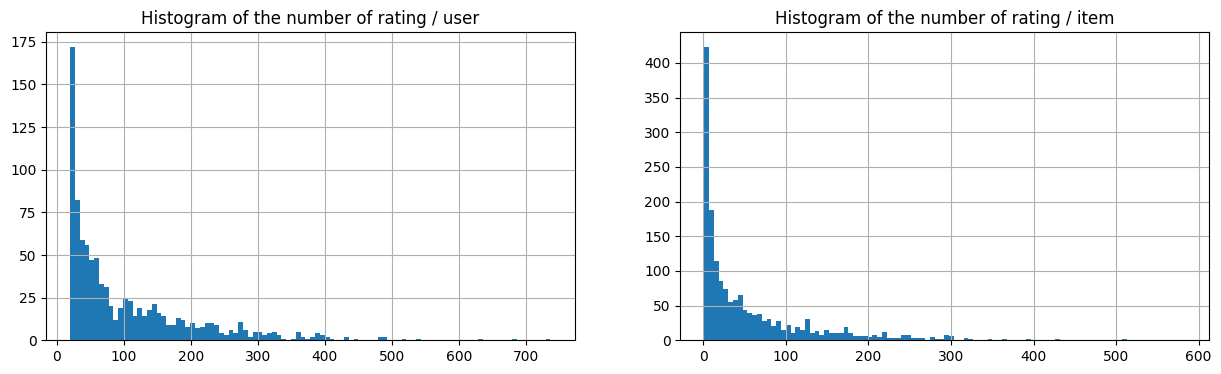

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ratings_df.groupby("user_id").count()["item_id"].hist(bins=100,ax=ax[0])
_ = ax[0].set_title("Histogram of the number of rating / user")

ratings_df.groupby("item_id").count()["user_id"].hist(bins=100,ax=ax[1])
_ = ax[1].set_title("Histogram of the number of rating / item")

In [20]:
ratings_df.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [21]:
ratings_df.shape

(100000, 4)

In [22]:
ratings = ratings_df[['user_id', 'item_id', 'rating']].values
ratings[:,0] -= 1
ratings[:,1] -= 1
print(ratings.shape,ratings.dtype)
for i in [0,1]:
    print("start indexing at:",np.min(ratings[:,i]),"end indexint at:",np.max(ratings[:,i]))

(100000, 3) int32
start indexing at: 0 end indexint at: 942
start indexing at: 0 end indexint at: 1681


942 users and 1682 unique users and items 
so total number of pairs is just 942 * 1682 


# Train Test Split 

In [23]:
def _create_sparse_train_and_test(ratings, n_users, n_items):
    print(ratings.shape,ratings.min(),n_users,n_items)
    # pick a random test set of entries, sorted ascending
    test_set_size = int(len(ratings) * TEST_SET_RATIO)
    np.random.seed(1)
    test_set_idx = np.random.choice(range(len(ratings)),
                                    size=test_set_size, replace=False)
    test_set_idx = sorted(test_set_idx)

    # sift ratings into train and test sets
    ts_ratings = ratings[test_set_idx]
    tr_ratings = np.delete(ratings, test_set_idx, axis=0)
    
    # create training and test matrices as coo_matrix's
    u_tr, i_tr, r_tr = zip(*tr_ratings)
    tr_sparse = coo_matrix((r_tr, (u_tr, i_tr)), shape=(n_users, n_items))

    u_ts, i_ts, r_ts = zip(*ts_ratings)
    test_sparse = coo_matrix((r_ts, (u_ts, i_ts)), shape=(n_users, n_items))

    return tr_sparse, test_sparse

## 10% of the data will be test set.
TEST_SET_RATIO = 0.1
tr_sparse, test_sparse = _create_sparse_train_and_test(ratings, n_users, n_items)

print("sparse matrix dimension:",tr_sparse.shape,tr_sparse.row.shape,tr_sparse.col.shape,tr_sparse.data.min())
print("sparse matrix dimension:",test_sparse.shape,test_sparse.row.shape,test_sparse.col.shape)

(100000, 3) 0 943 1682
sparse matrix dimension: (943, 1682) (90000,) (90000,) 1
sparse matrix dimension: (943, 1682) (10000,) (10000,)


In [24]:
def make_wts(data, wt_type, obs_wt, feature_wt_exp, axis):

    assert wt_type in ["LOG_RATINGS","LINEAR_RATINGS"]
    # recipricol of sum of number of items across rows (if axis is 0)
    frac = np.array(1.0/(data > 0.0).sum(axis))
    
    # filter any invalid entries
    frac[np.ma.masked_invalid(frac).mask] = 0.0
    
    # normalize weights according to assumed distribution of ratings
    if wt_type == "LOG_RATINGS":
        wts = np.array(np.power(frac, feature_wt_exp)).flatten()
    elif wt_type == "LINEAR_RATINGS":
        wts = np.array(obs_wt * frac).flatten()
    
    # check again for any numerically unstable entries
    assert np.isfinite(wts).sum() == wts.shape[0]
    return wts

#   obs_wt=189.8, feature_wt_exp=0.008 hyperparameter tuning 

(1682,)


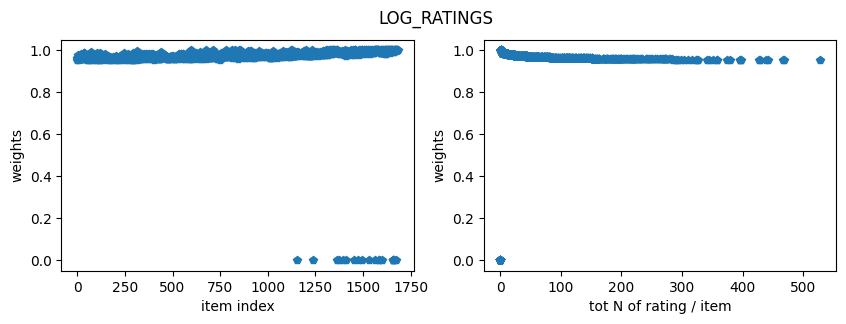

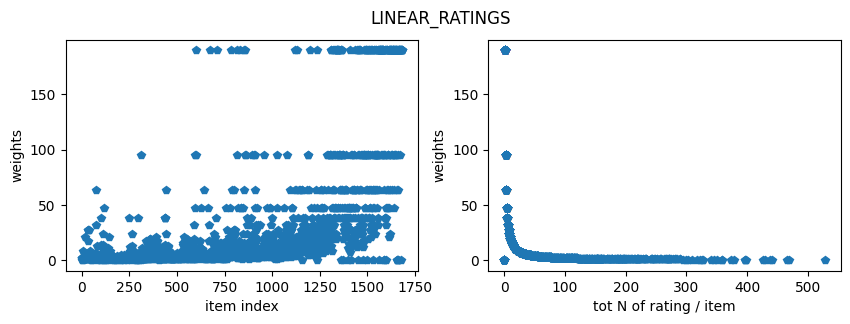

In [25]:
n_nonzero_items = np.array((tr_sparse > 0).sum(axis=0)).squeeze()
print(n_nonzero_items.shape)


def plot(col_wt,n_nonzero_items,title):
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    ax[0].plot(col_wt,"p")
    ax[0].set_xlabel("item index")
    ax[0].set_ylabel("weights")
    ax[1].plot(n_nonzero_items,col_wt,"p")
    ax[1].set_xlabel("tot N of rating / item")
    ax[1].set_ylabel("weights")
    plt.suptitle(title)
    plt.show()
    
for wt_type in ["LOG_RATINGS","LINEAR_RATINGS"]:    
    col_wt = make_wts(tr_sparse, wt_type, obs_wt=189.8, feature_wt_exp=0.008, axis=0)
    plot(col_wt,n_nonzero_items,title=wt_type)

In [26]:
def train(graph,model,input_tensor,verbose=False):
    sess = tf.Session(graph=graph)
    with graph.as_default():
        row_update_op = model.update_row_factors(sp_input=input_tensor)[1]
        col_update_op = model.update_col_factors(sp_input=input_tensor)[1]

        sess.run(model.initialize_op)
        sess.run(model.worker_init)
        for i in range(num_iterations):
            sess.run(model.row_update_prep_gramian_op)
            sess.run(model.initialize_row_update_op)
            sess.run(row_update_op)
            sess.run(model.col_update_prep_gramian_op)
            sess.run(model.initialize_col_update_op)
            sess.run(col_update_op)
            if verbose and i % 1 == 0:
                rf = sess.run(row_factor)
                print("iter",i,rf.mean(),rf.min(),sess.run(col_factor).mean())
    return sess 

import math
def get_rmse(output_row, output_col, actual):
        """Compute rmse between predicted and actual ratings.
        Args:
          output_row: evaluated numpy array of row_factor
          output_col: evaluated numpy array of col_factor
          actual: coo_matrix of actual (test) values
        Returns:
          rmse
        """
        mse = 0
        rate_preds = []
        for i in range(actual.data.shape[0]):
            row_pred = output_row[actual.row[i]]
            col_pred = output_col[actual.col[i]]
            rate_pred = np.dot(row_pred, col_pred)
            rate_preds.append(rate_pred)
            err = actual.data[i] - rate_pred
            mse += err * err
        mse /= actual.data.shape[0]
        rmse = math.sqrt(mse)
        return rmse,rate_preds

In [27]:
PARAMS = {
    'regularization': 0.01,
    'unobs_weight': .001,  
    'feature_wt_factor': 189.8,
    'feature_wt_exp': 0.08,
}

In [35]:
# create the rating matrix r_{ui}, remember to
# subract the user and item id by 1 since
# the indices starts from 0
n_users = ratings_df['user_id'].unique().shape[0]
n_items = ratings_df['item_id'].unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in ratings_df.itertuples(index = False):
    ratings[row.user_id - 1, row.item_id - 1] = row.rating

# compute the non-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
interaction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (interaction / matrix_size)

print('dimension: ', ratings.shape)
print('sparsity: {:.1f}%'.format(sparsity))
ratings

dimension:  (943, 1682)
sparsity: 6.3%


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

AttributeError: Polygon.set() got an unexpected keyword argument 'normed'

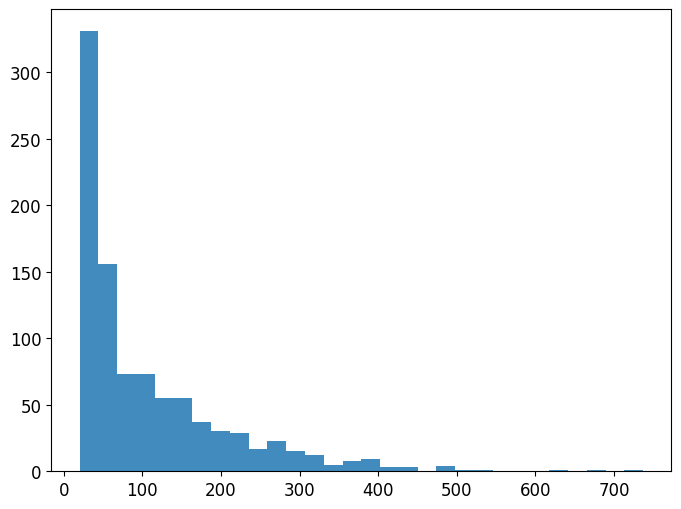

In [40]:
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

plt.hist(np.sum(ratings != 0, axis = 1), histtype = 'stepfilled', bins = 30,
         alpha = 0.85, label = '# of ratings', color = '#7A68A6', normed = True)
plt.axvline(x = 10, color = 'black', linestyle = '--')
plt.legend(loc = "upper right")
plt.show()

In [41]:
def create_train_test(ratings):

    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 10, replace = False)

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(ratings)
del ratings
train

array([[5., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix
    
    Parameters
    ----------
    n_iters : int
        number of iterations to train the algorithm
        
    n_factors : int
        number of latent factors to use in matrix 
        factorization model, some machine-learning libraries
        denote this as rank
        
    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train, test):
        """
        pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
        
        # record the training and testing mse for every iteration
        # to show convergence later (usually, not worth it for production)
        self.test_mse_record  = []
        self.train_mse_record = []   
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)
        
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        when updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self):
        """predict ratings for every user and item"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_mse(y_true, y_pred):
        """ignore zero terms prior to comparing the mse"""
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [43]:
def plot_learning_curve(model):
    """visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label = 'Test', linewidth = linewidth)
    plt.plot(model.train_mse_record, label = 'Train', linewidth = linewidth)
    plt.xlabel('iterations')
    plt.ylabel('MSE')
    plt.legend(loc = 'best')

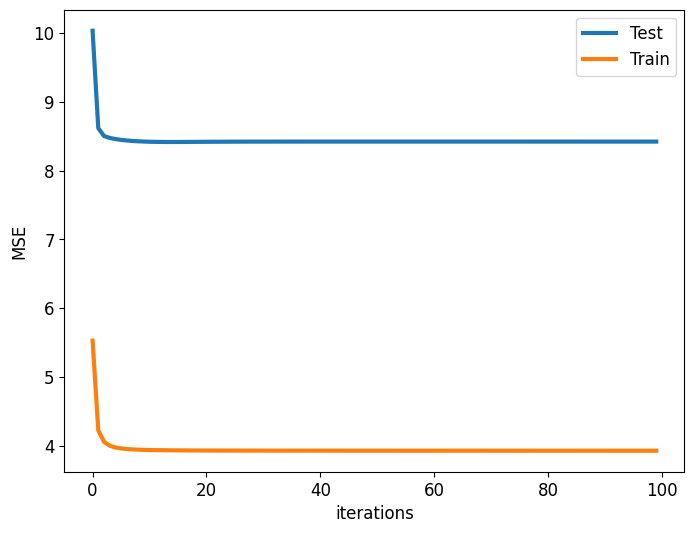

In [46]:
als = ExplicitMF(n_iters = 100, n_factors = 40, reg = 0.01)
als.fit(train, test)
plot_learning_curve(als)